In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/public_data_test/track_c/test/ind.csv
/kaggle/input/public_data_test/track_c/test/tat.csv
/kaggle/input/public_data_test/track_c/test/swe.csv
/kaggle/input/public_data_test/track_c/test/afr.csv
/kaggle/input/public_data_test/track_c/test/xho.csv
/kaggle/input/public_data_test/track_c/test/amh.csv
/kaggle/input/public_data_test/track_c/test/ptbr.csv
/kaggle/input/public_data_test/track_c/test/mar.csv
/kaggle/input/public_data_test/track_c/test/eng.csv
/kaggle/input/public_data_test/track_c/test/yor.csv
/kaggle/input/public_data_test/track_c/test/hau.csv
/kaggle/input/public_data_test/track_c/test/som.csv
/kaggle/input/public_data_test/track_c/test/ron.csv
/kaggle/input/public_data_test/track_c/test/zul.csv
/kaggle/input/public_data_test/track_c/test/sun.csv
/kaggle/input/public_data_test/track_c/test/arq.csv
/kaggle/input/public_data_test/track_c/test/hin.csv
/kaggle/input/public_data_test/track_c/test/ibo.csv
/kaggle/input/public_data_test/track_c/test/chn.csv
/kaggle/inp

# Install Libraries and Modules

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
!pip uninstall -y wandb

Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1


In [4]:
!pip install wandb==0.17.5 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.3 MB/s eta 0:00:0000:0100:01


In [5]:
import wandb

In [6]:
!wandb offline
!wandb disabled

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [7]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [8]:
!pip install datasets transformers evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [10]:
train_arq = pd.read_csv("/kaggle/input/public_data_test/track_a/train/arq.csv")
train_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/train/hin.csv")
train_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/train/swe.csv")


dev_arq = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/arq.csv")
dev_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/hin.csv")
dev_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/swe.csv")


test_arq = pd.read_csv("/kaggle/input/public_data_test/track_a/test/arq.csv")
test_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/test/hin.csv")
test_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/test/swe.csv")

# ALGERIAN ARABIC

## Sources:
- https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment
- https://huggingface.co/alger-ia
- https://huggingface.co/aubmindlab
- https://huggingface.co/Abdou

In [12]:
train_arq.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,arq_train_track_a_00001,عيني: عمر! رد بالك، تطلب السماح. ارواح هنا خير...,1,0,0,0,0,0
1,arq_train_track_a_00002,"عيني:""هو درّق وجهه تحت التراب و الهم طاح عليا!""",1,0,0,0,1,0
2,arq_train_track_a_00003,الراوي: في السحين طلعت الشمس و ريحة القهوة كان...,0,0,0,1,0,1
3,arq_train_track_a_00004,عيني: أنا يا عجوزة الڨاراڨوز؟ أنا نحسدك؟ أنا!؟,1,1,0,0,0,1
4,arq_train_track_a_00005,الراوي: كان حاس النجوم يشوفوا فيه و كلّ مرّة ن...,0,0,1,0,0,1


In [13]:
train_arq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        901 non-null    object
 1   text      901 non-null    object
 2   anger     901 non-null    int64 
 3   disgust   901 non-null    int64 
 4   fear      901 non-null    int64 
 5   joy       901 non-null    int64 
 6   sadness   901 non-null    int64 
 7   surprise  901 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 56.4+ KB


In [14]:
dev_arq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        100 non-null    object
 1   text      100 non-null    object
 2   anger     100 non-null    int64 
 3   disgust   100 non-null    int64 
 4   fear      100 non-null    int64 
 5   joy       100 non-null    int64 
 6   sadness   100 non-null    int64 
 7   surprise  100 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 6.4+ KB


<Axes: >

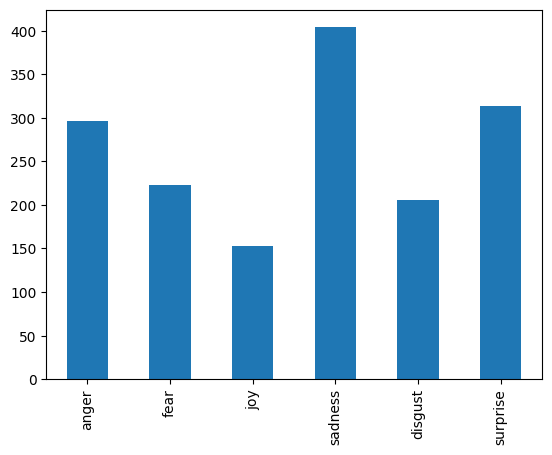

In [16]:
attributes = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']
train_arq[attributes].sum().plot.bar()

<Axes: >

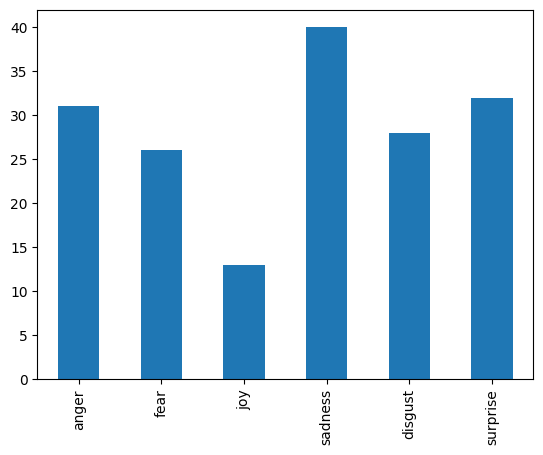

In [17]:
dev_arq[attributes].sum().plot.bar()

In [18]:
test_arq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        902 non-null    object 
 1   text      902 non-null    object 
 2   anger     0 non-null      float64
 3   disgust   0 non-null      float64
 4   fear      0 non-null      float64
 5   joy       0 non-null      float64
 6   sadness   0 non-null      float64
 7   surprise  0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 56.5+ KB


In [19]:
test_arq.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,arq_test_track_a_00001,الراوي: كانت تدي حفنة لوبيا يابسة، تزربع الحبا...,NaN,NaN,NaN,NaN,NaN,NaN
1,arq_test_track_a_00002,بصّح عمر خمم: يمّاه زعمة تقدر تهرب للدّيوانة؟,NaN,NaN,NaN,NaN,NaN,NaN
2,arq_test_track_a_00003,"امالا كان لازم على عمر يكدب و يكمل: ""النار شاع...",NaN,NaN,NaN,NaN,NaN,NaN
3,arq_test_track_a_00004,الراوي: الحالة كانت مهوّلة اليوم، وعلاه كان ال...,NaN,NaN,NaN,NaN,NaN,NaN
4,arq_test_track_a_00005,الراوي: و كان هاذ الشي محيّر الناس لا خاطرش كا...,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('alger-ia/dziribert_sentiment')
model = AutoModelForSequenceClassification.from_pretrained('alger-ia/dziribert_sentiment',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/446k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert_sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

In [ ]:
def encode_data(df, tokenizer):
    encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=128)
    labels = df[emotion_labels].fillna(0).values
    return encodings, labels

In [15]:
train_encodings, train_labels = encode_data(train_arq, tokenizer)
dev_encodings, dev_labels = encode_data(dev_arq, tokenizer)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [17]:
train_dataset = CustomDataset(train_encodings, train_labels)
dev_dataset = CustomDataset(dev_encodings, dev_labels)

In [21]:
train_dataset

In [ ]:
train_dataset.encodings

In [ ]:
def calculate_token_lengths(texts, tokenizer):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

train_lengths = calculate_token_lengths(train_arq['text'], tokenizer)
dev_lengths = calculate_token_lengths(dev_arq['text'], tokenizer)
test_lengths = calculate_token_lengths(test_arq['text'], tokenizer)

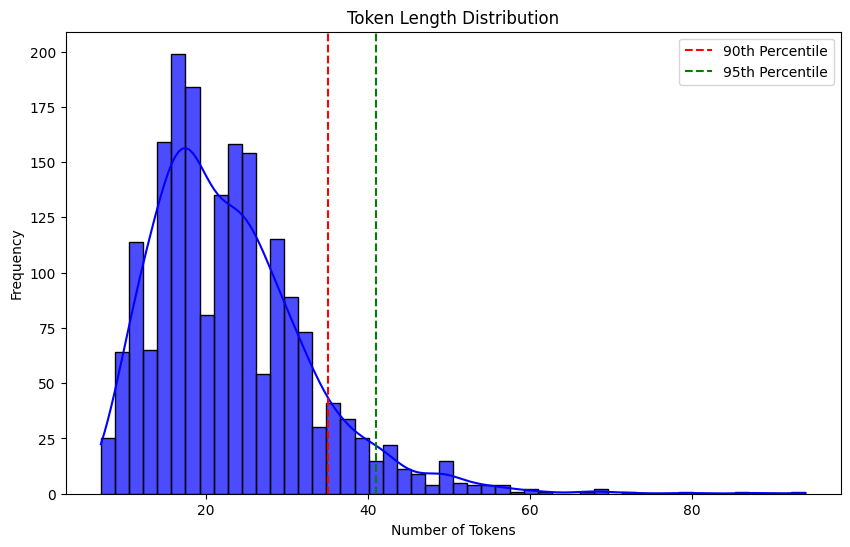

In [ ]:
all_lengths = train_lengths + dev_lengths + test_lengths

plt.figure(figsize=(10, 6))
sns.histplot(all_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(x=np.percentile(all_lengths, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(x=np.percentile(all_lengths, 95), color='green', linestyle='--', label='95th Percentile')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
def compute_metrics(pred, threshold=0.3):
    logits, labels = pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > threshold).numpy()
    labels = labels.astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': np.mean(f1),
        'precision': np.mean(precision),
        'recall': np.mean(recall),
    }


In [ ]:
training_args = TrainingArguments(
    output_dir='./results/arq/dziribert-sentiment-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [21]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [22]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.243800,0.534864,0.160000,0.574186,0.515568,0.682353
1000,0.066500,0.666178,0.230000,0.590023,0.595097,0.629412
1500,0.024600,0.780978,0.230000,0.566835,0.589083,0.605882
2000,0.013600,0.850280,0.210000,0.579477,0.586587,0.617647
2500,0.010000,0.909857,0.240000,0.570387,0.582247,0.600000
3000,0.007300,0.944938,0.260000,0.583604,0.607937,0.605882
3500,0.005800,0.973439,0.240000,0.567253,0.588206,0.582353
4000,0.004800,0.993785,0.240000,0.580065,0.587231,0.611765
4500,0.004300,1.020504,0.240000,0.574638,0.592722,0.600000
5000,0.003900,1.034210,0.240000,0.567671,0.604549,0.576471


In [ ]:
def find_best_threshold(pred, thresholds):
    best_threshold = 0.5
    best_f1 = 0
    
    for t in thresholds:
        metrics = compute_metrics(pred, threshold=t)
        print(f"metrics: {metrics}")
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = t

    return best_threshold, best_f1

In [ ]:
def evaluate_on_validation_set(trainer, threshold_range=np.linspace(0.1, 0.9, 9)):
    predictions, labels, _ = trainer.predict(dev_dataset)  
    pred = (predictions, labels)

    best_threshold, best_f1 = find_best_threshold(pred, thresholds=threshold_range)
    print("----------------------------------------------")
    print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1:.4f}")
    print("***********************************************")
    final_metrics = compute_metrics(pred, threshold=best_threshold)
    print(f"Metrics with Best Threshold: {final_metrics}")

    return best_threshold, final_metrics

In [25]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.04, 'f1': 0.5726025863729849, 'precision': 0.42353009879726367, 'recall': 0.8941176470588236}
metrics: {'accuracy': 0.15, 'f1': 0.5811849530977418, 'precision': 0.4965305436296073, 'recall': 0.7352941176470589}
metrics: {'accuracy': 0.16, 'f1': 0.5741856480531462, 'precision': 0.5155681732152321, 'recall': 0.6823529411764706}
metrics: {'accuracy': 0.2, 'f1': 0.5588846641334566, 'precision': 0.5467187922124194, 'recall': 0.611764705882353}
metrics: {'accuracy': 0.21, 'f1': 0.5463531489760998, 'precision': 0.575020903675528, 'recall': 0.5647058823529412}
metrics: {'accuracy': 0.25, 'f1': 0.5343938474160655, 'precision': 0.6340539852304559, 'recall': 0.5}
metrics: {'accuracy': 0.22, 'f1': 0.4780380583534375, 'precision': 0.6591926751217007, 'recall': 0.4117647058823529}
metrics: {'accuracy': 0.22, 'f1': 0.42907923565357203, 'precision': 0.7021060569976978, 'recall': 0.3411764705882353}
metrics: {'accuracy': 0.15, 'f1': 0.3201072183397356, 'precision': 0.71981580510

In [ ]:
dev_results = trainer.predict(dev_dataset)

predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.2).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

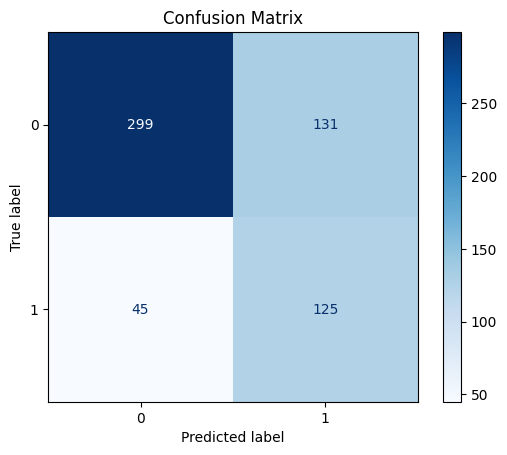

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

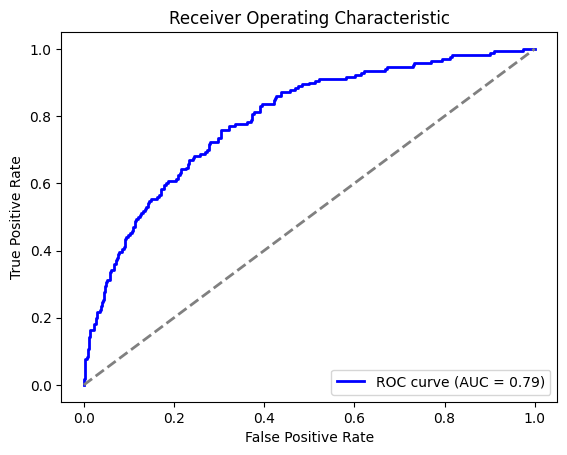

In [ ]:
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(emotion_labels):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.1500
anger: Precision=0.4681, Recall=0.7097, F1=0.5641
disgust: Precision=0.5667, Recall=0.6071, F1=0.5862
fear: Precision=0.4255, Recall=0.7692, F1=0.5479
joy: Precision=0.5556, Recall=0.3846, F1=0.4545
sadness: Precision=0.4937, Recall=0.9750, F1=0.6555
surprise: Precision=0.5000, Recall=0.6875, F1=0.5789


In [ ]:
test_encodings = tokenizer(list(test_arq['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_arq), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.2).numpy()

In [ ]:
test_arq[emotion_labels] = test_predictions
test_arq.to_csv('test_predictions_arq_dziribert_sentiment_v1.csv', index=False)

In [34]:
test_arq.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,arq_test_track_a_00001,الراوي: كانت تدي حفنة لوبيا يابسة، تزربع الحبا...,False,False,False,False,True,False
1,arq_test_track_a_00002,بصّح عمر خمم: يمّاه زعمة تقدر تهرب للدّيوانة؟,True,True,True,False,True,True
2,arq_test_track_a_00003,"امالا كان لازم على عمر يكدب و يكمل: ""النار شاع...",True,True,False,False,True,False
3,arq_test_track_a_00004,الراوي: الحالة كانت مهوّلة اليوم، وعلاه كان ال...,False,False,True,False,True,True
4,arq_test_track_a_00005,الراوي: و كان هاذ الشي محيّر الناس لا خاطرش كا...,False,False,False,True,False,True
